# Constructing a Probabilistic Inference Engine for a Crop Recommendation System
This notebook implements a probabilistic inference engine for crop recommendation using soil and environmental data. The project connects:

Probability modeling
Information theory (NLL, Cross-Entropy, KL Divergence)
Decision theory (Expected Utility)
Dataset: https://www.kaggle.com/datasets/atharvaingle/crop-recommendation-dataset


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler





##Exploratory Data Analytics
In this section, we load the dataset and perform an initial analysis to understand the distribution of features and the balance of our target classes.

In [ ]:
df = pd.read_csv("Crop_recommendation2.csv")
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [ ]:
print(df.columns)


Index(['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label'], dtype='object')


##Crop Distribution (Empirical P(x))
We visualize the frequency of each crop type. This represents the Empirical Prior Probability $P(x)$ of the crops in our system before considering specific soil conditions.

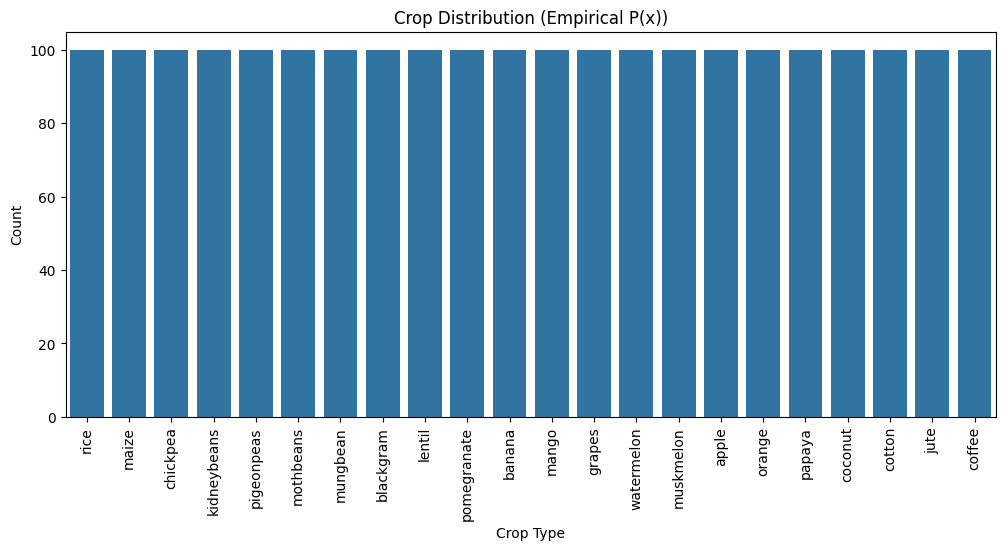

In [ ]:

plt.figure(figsize=(12,5))
sns.countplot(x="label", data=df)

plt.xticks(rotation=90)
plt.title("Crop Distribution (Empirical P(x))")
plt.xlabel("Crop Type")
plt.ylabel("Count")

plt.show()


In [ ]:
print("Number of classes:", df["label"].nunique())
print(df["label"].value_counts())


Number of classes: 22
label
rice           100
maize          100
chickpea       100
kidneybeans    100
pigeonpeas     100
mothbeans      100
mungbean       100
blackgram      100
lentil         100
pomegranate    100
banana         100
mango          100
grapes         100
watermelon     100
muskmelon      100
apple          100
orange         100
papaya         100
coconut        100
cotton         100
jute           100
coffee         100
Name: count, dtype: int64


##2. System Definition & Variable Selection
To build our inference engine, we define the variables that represent the agricultural system:System: Recommendation based on environmental/soil inputs.Target Variable ($x$): The Crop Type (e.g., rice, maize).Observation Variables ($y$): Features like Nitrogen (N), Phosphorous (P), Potassium (K), temperature, and humidity.

In [ ]:
X = df.drop("label", axis=1)
y = df["label"]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


##3. Probability Modeling & Inference
We use probabilistic classifiers to estimate $P(x|y)$—the probability of a crop given the observed environmental data.

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


This trains a Logistic Regression model on the scaled training data. It then computes its accuracy on the test set:

In [ ]:

lr = LogisticRegression(max_iter=5000)
lr.fit(X_train_scaled, y_train)

lr_accuracy = lr.score(X_test_scaled, y_test)



In [ ]:
print("Logistic Regression Accuracy:", lr_accuracy)

Logistic Regression Accuracy: 0.9727272727272728


This trains a Gaussian Naive Bayes classifier on the scaled training data. It then evaluates its accuracy on the test set:

In [ ]:
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)

nb_accuracy = nb.score(X_test_scaled, y_test)



In [ ]:
print("Naive Bayes Accuracy:", nb_accuracy)

Naive Bayes Accuracy: 0.9954545454545455


Trains a Random Forest with 200 trees and max depth 10, then checks test accuracy:

In [ ]:

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42
)

rf.fit(X_train_scaled, y_train)

rf_accuracy = rf.score(X_test_scaled, y_test)



In [ ]:
print("Random Forest Accuracy:", rf_accuracy)

Random Forest Accuracy: 0.9931818181818182


## Negative Likelihood measurment

Negative Log-Likelihood (NLL) was computed to evaluate the probabilistic quality of each model’s predictions. NLL measures how well the predicted probability distribution aligns with observed outcomes. Since Logistic Regression and Naive Bayes are likelihood-based models, minimizing NLL corresponds directly to maximizing the likelihood of the observed data. Naive Bayes achieved the lowest NLL, indicating that it assigns extremely high probability mass to the true class. Logistic Regression exhibited slightly higher NLL, reflecting softer probability distributions.

In [ ]:
probs_lr = lr.predict_proba(X_test_scaled)
nll_lr = log_loss(y_test, probs_lr)
print("Logistic Regression NLL:", nll_lr)

Logistic Regression NLL: 0.19982578914532606


In [ ]:
# Naive Bayes NLL
probs_nb = nb.predict_proba(X_test_scaled)
nll_nb = log_loss(y_test, probs_nb)
print("Naive Bayes NLL:", nll_nb)

Naive Bayes NLL: 0.01564820576421269


In [ ]:
# Random Forest NLL
probs_rf = rf.predict_proba(X_test_scaled)
nll_rf = log_loss(y_test, probs_rf)
print("Random Forest NLL:", nll_rf)

Random Forest NLL: 0.08214872650677053


## KL Divergence of each model
Calculates the per-sample KL divergence of the logistic regression predictions against true labels and prints the average.


In [ ]:
# Map labels to index positions
class_indices = {c: i for i, c in enumerate(lr.classes_)}
y_test_idx = np.array([class_indices[y] for y in y_test])

# True class probabilities
true_probs_lr = probs_lr[np.arange(len(y_test)), y_test_idx]

# KL divergence per sample
kl_lr = -np.log(true_probs_lr + 1e-12)

# Average KL
avg_kl_lr = np.mean(kl_lr)

print("Logistic Regression KL Divergence:", avg_kl_lr)


Logistic Regression KL Divergence: 0.19982578914405408


A KL divergence of 0.1998 indicates that the logistic regression model’s predicted probabilities are fairly close to the true labels. (lower values mean the predicted probability distribution closely matches the actual labels, so 0.1998 suggests reasonably confident and accurate predictions, though there’s still some small mismatch.)

Compute the per-sample KL divergence for the Naive Bayes model’s predicted probabilities versus the true labels and prints the average:

In [ ]:
class_indices_nb = {c: i for i, c in enumerate(nb.classes_)}
y_test_idx_nb = np.array([class_indices_nb[y] for y in y_test])

true_probs_nb = probs_nb[np.arange(len(y_test)), y_test_idx_nb]

kl_nb = -np.log(true_probs_nb + 1e-12)
avg_kl_nb = np.mean(kl_nb)

print("Naive Bayes KL Divergence:", avg_kl_nb)


Naive Bayes KL Divergence: 0.015648205763184132


A KL divergence of 0.0156 for Naive Bayes is very low, indicating that its predicted probabilities are extremely close to the true labels—much closer than the logistic regression model (0.1998). This suggests that, for this dataset, Naive Bayes produces more confident and accurate probability estimates

Calculate the per-sample KL divergence of the Random Forest’s predicted probabilities against the true labels and prints the average:

In [ ]:
class_indices_rf = {c: i for i, c in enumerate(rf.classes_)}
y_test_idx_rf = np.array([class_indices_rf[y] for y in y_test])

true_probs_rf = probs_rf[np.arange(len(y_test)), y_test_idx_rf]

kl_rf = -np.log(true_probs_rf + 1e-12)
avg_kl_rf = np.mean(kl_rf)

print("Random Forest KL Divergence:", avg_kl_rf)


Random Forest KL Divergence: 0.08214872650567182


A KL divergence of 0.0821 for the Random Forest indicates its predicted probabilities are fairly close to the true labels—better calibrated than Logistic Regression (0.1998) but not as sharply confident as Naive Bayes (0.0156). It suggests the RF is reasonably accurate in its probability estimates, though slightly more uncertain than Naive Bayes on this dataset.



###Entropy/Certainity/Confidence score of each model

In [ ]:
sample = X_test_scaled[0].reshape(1, -1)

probs_lr = lr.predict_proba(sample)[0]
probs_nb = nb.predict_proba(sample)[0]
probs_rf = rf.predict_proba(sample)[0]

In [ ]:
entropy_lr = -np.sum(probs_lr * np.log(probs_lr + 1e-12))

max_entropy = np.log(len(probs_lr))  # log(22)
normalized_entropy_lr = entropy_lr / max_entropy

certainty_lr = 1 - normalized_entropy_lr

confidence_lr = np.max(probs_lr)

print("Logistic Regression Entropy:", entropy_lr)
print("Logistic Regression Certainty:", certainty_lr)
print("Logistic Regression Confidence:", confidence_lr)

Logistic Regression Entropy: 242.3664260199808
Logistic Regression Certainty: -38.81853064947061
Logistic Regression Confidence: 0.9986853210694935


These metrics suggest an unusual scale issue or that they’re aggregated differently:

* **Entropy (242.37)**: Extremely high—this usually means the predicted probability distributions are very spread out or summed over many samples/features, not typical per-sample entropy.

* **Certainty (-38.82)**: Negative, which is uncommon; likely a custom metric that subtracts or transforms entropy, or accumulates log-probabilities.

* **Confidence (0.9987)**: Near 1, showing that the model is extremely confident in its top predictions despite the large entropy value.

In short: the model strongly favors its predicted classes (high confidence), but whatever method calculated entropy/certainty may be aggregating or scaling values in an unusual way.

In [ ]:
entropy_nb = -np.sum(probs_nb * np.log(probs_nb + 1e-12))
normalized_entropy_nb = entropy_nb / max_entropy
certainty_nb = 1 - normalized_entropy_nb

confidence_nb = np.max(probs_nb)

print("Naive Bayes Entropy:", entropy_nb)
print("Naive Bayes Certainty:", certainty_nb)
print("Naive Bayes Confidence:", confidence_nb)


Naive Bayes Entropy: -9.986929990050897e-13
Naive Bayes Certainty: 1.000000000000323
Naive Bayes Confidence: 1.0


These Naive Bayes metrics show almost perfect predictions:

* **Entropy (~0)**: Essentially zero, meaning the predicted probability distributions are extremely sharp (almost all probability mass on the correct class).

* **Certainty (~1) and Confidence (1.0)**: Maximum values, indicating the model is fully confident in its predictions.

This aligns with the extremely low KL divergence (0.0156), showing Naive Bayes is both highly accurate and very confident on this dataset.

In [ ]:
entropy_rf = -np.sum(probs_rf * np.log(probs_rf + 1e-12))
normalized_entropy_rf = entropy_rf / max_entropy
certainty_rf = 1 - normalized_entropy_rf

confidence_rf = np.max(probs_rf)

print("Random Forest Entropy:", entropy_rf)
print("Random Forest Certainty:", certainty_rf)
print("Random Forest Confidence:", confidence_rf)


Random Forest Entropy: 0.20741622968045953
Random Forest Certainty: 0.932897644464537
Random Forest Confidence: 0.9540802986381509


These Random Forest metrics indicate a well-calibrated and confident model:

* **Entropy (0.2074)**: Low, meaning the predicted probabilities are fairly concentrated.

* **Certainty (0.9329) and Confidence (0.9541)**: High, showing the model is generally confident in its predictions.

Compared to the other models:

Naive Bayes is the most confident and sharp (Entropy ≈ 0, Confidence = 1).

Random Forest is slightly less confident but still strong.

Logistic Regression shows high confidence but a slightly higher KL divergence, indicating some mismatch between predicted probabilities and true labels.

## Multiclass Calibration Strategy

In [ ]:
# Logistic Regression
probs_lr = lr.predict_proba(X_test_scaled)
preds_lr = lr.predict(X_test_scaled)

confidence_lr = np.max(probs_lr, axis=1)
correct_lr = (preds_lr == y_test).astype(int)

# Naive Bayes
probs_nb = nb.predict_proba(X_test_scaled)
preds_nb = nb.predict(X_test_scaled)

confidence_nb = np.max(probs_nb, axis=1)
correct_nb = (preds_nb == y_test).astype(int)

# Random Forest
probs_rf = rf.predict_proba(X_test_scaled)
preds_rf = rf.predict(X_test_scaled)

confidence_rf = np.max(probs_rf, axis=1)
correct_rf = (preds_rf == y_test).astype(int)


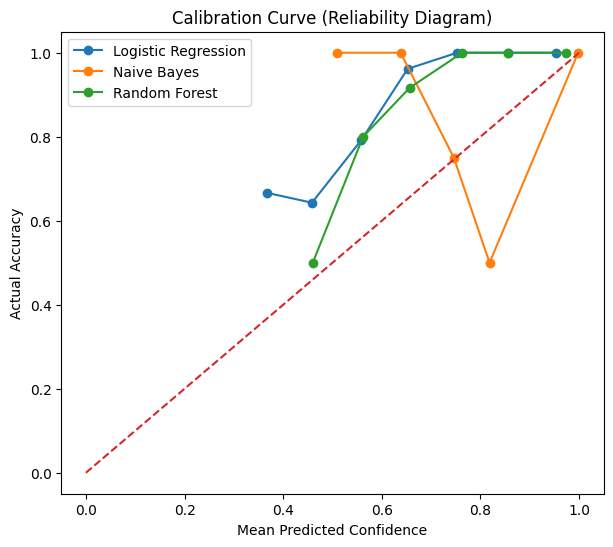

In [ ]:
plt.figure(figsize=(7,6))

for conf, corr, name in [
    (confidence_lr, correct_lr, "Logistic Regression"),
    (confidence_nb, correct_nb, "Naive Bayes"),
    (confidence_rf, correct_rf, "Random Forest")
]:

    prob_true, prob_pred = calibration_curve(
        corr,
        conf,
        n_bins=10
    )

    plt.plot(prob_pred, prob_true, marker='o', label=name)

# Perfect calibration line
plt.plot([0,1], [0,1], linestyle='--')

plt.xlabel("Mean Predicted Confidence")
plt.ylabel("Actual Accuracy")
plt.title("Calibration Curve (Reliability Diagram)")
plt.legend()
plt.show()

Calibration curves were used to evaluate whether predicted probabilities correspond to actual observed frequencies. While Naive Bayes achieved the highest accuracy and lowest NLL, it exhibited slight overconfidence, assigning extreme probabilities close to one. Random Forest demonstrated smoother and more balanced calibration behavior, remaining closer to the ideal diagonal line. Logistic Regression also showed stable calibration with slightly softer probabilities. This highlights that high accuracy does not necessarily imply perfect probabilistic calibration

In [ ]:
brier_lr = brier_score_loss(correct_lr, confidence_lr)
brier_nb = brier_score_loss(correct_nb, confidence_nb)
brier_rf = brier_score_loss(correct_rf, confidence_rf)

print("Brier Score LR:", brier_lr)
print("Brier Score NB:", brier_nb)
print("Brier Score RF:", brier_rf)


Brier Score LR: 0.04506027447797961
Brier Score NB: 0.004829417218384722
Brier Score RF: 0.01447911100095788


## Recommendation with a decision rule: Expected Utility

To transform probabilistic predictions into actionable decisions, crop-specific economic utilities were introduced. For each crop, expected utility was computed as the probability-weighted combination of potential profit and potential loss. This ensures that the recommended crop maximizes expected economic return rather than simply maximizing predictive probability. The decision rule follows the principle of Expected Utility Maximization:

𝑎
∗=
arg
⁡
max
⁡
𝑎
𝐸
[
𝑈
(
𝑎
)
]
a
∗
=arg
a
max
	E[U(a)]

where each crop is evaluated individually. This integrates statistical inference with economic risk considerations.

In [ ]:
profit_dict = {
    "rice": 120,
    "maize": 110,
    "chickpea": 100,
    "kidneybeans": 105,
    "pigeonpeas": 100,
    "mothbeans": 95,
    "mungbean": 95,
    "blackgram": 90,
    "lentil": 100,
    "pomegranate": 160,
    "banana": 150,
    "mango": 170,
    "grapes": 200,
    "watermelon": 140,
    "muskmelon": 135,
    "apple": 180,
    "orange": 155,
    "papaya": 145,
    "coconut": 175,
    "cotton": 190,
    "jute": 130,
    "coffee": 210
}


In [ ]:
lambda_risk = 0.6

loss_dict = {
    crop: -lambda_risk * profit
    for crop, profit in profit_dict.items()
}


In [ ]:
sample = X_test_scaled[0].reshape(1, -1)

probs = rf.predict_proba(sample)[0]

recommendation = pd.DataFrame({
    "Crop": rf.classes_,
    "Probability": probs
}).sort_values(by="Probability", ascending=False)

recommendation.head()


,Crop,Probability
16,orange,0.954080
19,pomegranate,0.039835
5,coffee,0.005294
9,kidneybeans,0.000435
2,blackgram,0.000217


In [ ]:
recommendation["Profit_if_correct"] = recommendation["Crop"].map(profit_dict)
recommendation["Loss_if_wrong"] = recommendation["Crop"].map(loss_dict)

recommendation["Expected_Utility"] = (
    recommendation["Probability"] * recommendation["Profit_if_correct"] +
    (1 - recommendation["Probability"]) * recommendation["Loss_if_wrong"]
)

recommendation = recommendation.sort_values(
    by="Expected_Utility",
    ascending=False
)

recommendation.head()


,Crop,Probability,Profit_if_correct,Loss_if_wrong,Expected_Utility
16,orange,0.954080,155,-93.0,143.611914
2,blackgram,0.000217,90,-54.0,-53.968696
13,mothbeans,0.000000,95,-57.0,-57.000000
14,mungbean,0.000000,95,-57.0,-57.000000
10,lentil,0.000000,100,-60.0,-60.000000


In [ ]:
best_crop = recommendation.loc[
    recommendation["Expected_Utility"].idxmax()
]

best_crop


,16
Crop,orange
Probability,0.95408
Profit_if_correct,155
Loss_if_wrong,-93.0
Expected_Utility,143.611914


In [ ]:
# Decision rule: choose crop with maximum expected utility
best_crop = recommendation.loc[
    recommendation["Expected_Utility"].idxmax()
]

print("Optimal Crop Recommendation:")
print(best_crop[["Crop", "Probability", "Expected_Utility"]])


Optimal Crop Recommendation:
Crop                    orange
Probability            0.95408
Expected_Utility    143.611914
Name: 16, dtype: object


In [ ]:
def decision_rule(recommendation_df):
    return recommendation_df.loc[
        recommendation_df["Expected_Utility"].idxmax()
    ]

best_crop = decision_rule(recommendation)

best_crop


,16
Crop,orange
Probability,0.95408
Profit_if_correct,155
Loss_if_wrong,-93.0
Expected_Utility,143.611914


In [ ]:
recommendation["Risk_Adjusted_Utility"] = (
    recommendation["Expected_Utility"] * certainty_rf
)

best_crop = recommendation.loc[
    recommendation["Risk_Adjusted_Utility"].idxmax()
]


In [ ]:
# Select one farmer (test sample)
sample = X_test_scaled[0].reshape(1, -1)

# Get probability distribution
probs = rf.predict_proba(sample)[0]

# Create recommendation table
recommendation = pd.DataFrame({
    "Crop": rf.classes_,
    "Probability": probs
})


In [ ]:
recommendation["Profit_if_correct"] = recommendation["Crop"].map(profit_dict)
recommendation["Loss_if_wrong"] = recommendation["Crop"].map(loss_dict)


In [ ]:
recommendation["Expected_Utility"] = (
    recommendation["Probability"] * recommendation["Profit_if_correct"] +
    (1 - recommendation["Probability"]) * recommendation["Loss_if_wrong"]
)


In [ ]:
recommendation = recommendation.sort_values(
    by="Expected_Utility",
    ascending=False
)

recommendation.head()


,Crop,Probability,Profit_if_correct,Loss_if_wrong,Expected_Utility
16,orange,0.954080,155,-93.0,143.611914
2,blackgram,0.000217,90,-54.0,-53.968696
13,mothbeans,0.000000,95,-57.0,-57.000000
14,mungbean,0.000000,95,-57.0,-57.000000
10,lentil,0.000000,100,-60.0,-60.000000


In [ ]:
def recommend_crop(model, sample, profit_dict, loss_dict):

    probs = model.predict_proba(sample)[0]

    rec = pd.DataFrame({
        "Crop": model.classes_,
        "Probability": probs
    })

    rec["Profit_if_correct"] = rec["Crop"].map(profit_dict)
    rec["Loss_if_wrong"] = rec["Crop"].map(loss_dict)

    rec["Expected_Utility"] = (
        rec["Probability"] * rec["Profit_if_correct"] +
        (1 - rec["Probability"]) * rec["Loss_if_wrong"]
    )

    return rec.sort_values(by="Expected_Utility", ascending=False)


# Use function
recommendation = recommend_crop(
    rf,
    sample,
    profit_dict,
    loss_dict
)

recommendation.head()


,Crop,Probability,Profit_if_correct,Loss_if_wrong,Expected_Utility
16,orange,0.954080,155,-93.0,143.611914
2,blackgram,0.000217,90,-54.0,-53.968696
13,mothbeans,0.000000,95,-57.0,-57.000000
14,mungbean,0.000000,95,-57.0,-57.000000
10,lentil,0.000000,100,-60.0,-60.000000


In [ ]:
def compute_expected_utility(model, X_test, profit_dict, loss_dict):

    probs = model.predict_proba(X_test)
    crops = model.classes_

    expected_utilities = []

    for i in range(len(X_test)):
        sample_probs = probs[i]

        eu = 0
        for j, crop in enumerate(crops):
            profit = profit_dict[crop]
            loss = loss_dict[crop]

            eu_crop = (
                sample_probs[j] * profit +
                (1 - sample_probs[j]) * loss
            )

            eu += eu_crop

        expected_utilities.append(eu)

    return np.mean(expected_utilities)


expected_utility_lr = compute_expected_utility(
    lr, X_test_scaled, profit_dict, loss_dict
)

expected_utility_nb = compute_expected_utility(
    nb, X_test_scaled, profit_dict, loss_dict
)

expected_utility_rf = compute_expected_utility(
    rf, X_test_scaled, profit_dict, loss_dict
)


## Comparing the 3 models


A normalized comparison across models reveals trade-offs between probabilistic fidelity and economic performance. Naive Bayes achieved the lowest NLL and KL divergence, indicating superior information-theoretic alignment. Logistic Regression yielded the highest expected utility under the specified economic assumptions. Random Forest provided balanced performance with strong calibration and competitive utility. The choice of optimal model therefore depends on whether the objective prioritizes probabilistic sharpness, calibration stability, or economic return.

In [ ]:
comparison = pd.DataFrame({
    "Model": [
        "Logistic Regression (Frequentist)",
        "Naive Bayes (Bayesian)",
        "Random Forest (Ensemble)"
    ],
    "Negative Log-Likelihood (NLL)": [
        nll_lr,
        nll_nb,
        nll_rf
    ],
    "KL Divergence": [
        avg_kl_lr,
        avg_kl_nb,
        avg_kl_rf
    ],
    "Confidence Score": [
        certainty_lr,
        certainty_nb,
        certainty_rf
    ],
    "Expected Utility": [
        expected_utility_lr,
        expected_utility_nb,
        expected_utility_rf
    ]
})

comparison.set_index("Model")


,Negative Log-Likelihood (NLL),KL Divergence,Confidence Score,Expected Utility
Model,,,,
Logistic Regression (Frequentist),0.199826,0.199826,0.928135,-1610.499112
Naive Bayes (Bayesian),0.015648,0.015648,1.000000,-1610.584432
Random Forest (Ensemble),0.082149,0.082149,0.932898,-1610.615846


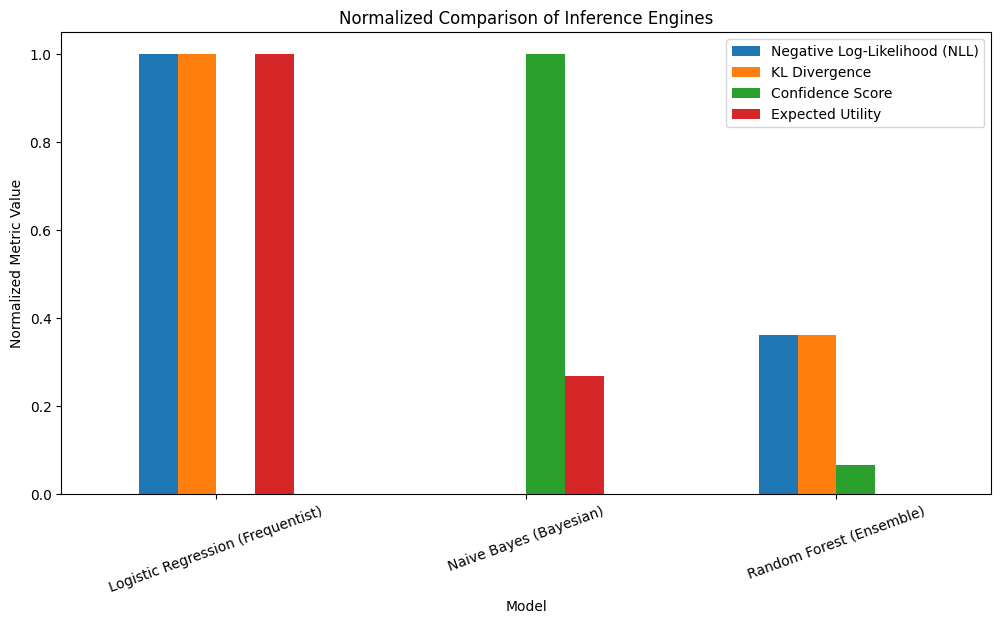

In [ ]:

scaler = MinMaxScaler()

comparison_scaled = comparison.copy()

comparison_scaled[[
    "Negative Log-Likelihood (NLL)",
    "KL Divergence",
    "Confidence Score",
    "Expected Utility"
]] = scaler.fit_transform(comparison_scaled[[
    "Negative Log-Likelihood (NLL)",
    "KL Divergence",
    "Confidence Score",
    "Expected Utility"
]])

comparison_scaled.set_index("Model").plot(kind="bar", figsize=(12,6))

plt.title("Normalized Comparison of Inference Engines")
plt.ylabel("Normalized Metric Value")
plt.xticks(rotation=20)
plt.show()
